# Notes

This notebook attempts to plot the baryonic mass fraction of halos, filaments and voids in the IllustrisTNG simulation in the style of Figure 2 from Martizzi+19 (https://arxiv.org/abs/1810.01883) and Figure A.1 from Artale+21 (https://arxiv.org/abs/2102.01092)

Code is adapted from Plot_evolving_density_structures.ipynb

# Imports

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import yt
import trident
from trident import LightRay
import illustris_python as il
from astropy import units as u
from astropy import constants as c
from yt.utilities.cosmology import Cosmology
from matplotlib import pyplot as plt


# Choose snapshots and chunks and TNG100 version to plot for

In [2]:
snapshots = [99,84,78,72,67,59,50,40,33,25,21,17]#,13,11,8,6,4,3,2]
chunks = [0]#,1,2,3,4,5,6] #each TNG100-3 snapshot has chunks running from 0 to 6 inclusive
TNGversion = 2 # 1=TNG100-1, 2=TNG100-2, 3=TNG100-3

# Begin

In [ ]:
######################################
#initialise arrays that hold all data#
######################################

#redshift array
allsnaps_redshifts=[]

#baryon arrays
#PartType0 (gas)
allsnaps_tot_PT0_arr = []
allsnaps_hal_PT0_arr = []
allsnaps_fil_PT0_arr = []
allsnaps_voi_PT0_arr = []
#PartType4 (stars)
allsnaps_tot_PT4_arr = []
allsnaps_hal_PT4_arr = []
allsnaps_fil_PT4_arr = []
allsnaps_voi_PT4_arr = []

#check arrays
allsnaps_dens_crit_array = []
allsnaps_m_p_array = []
#norm_factor = []

################################
#loop over snapshots and chunks#
################################

for i in range(len(snapshots)):
    
    ######################################################
    #initialise arrays that hold individual snapshot data#
    ######################################################

    #redshift array
    redshifts=[]

    #baryon arrays
    #PartType0 (gas)
    tot_PT0_arr = []
    hal_PT0_arr = []
    fil_PT0_arr = []
    voi_PT0_arr = []
    #PartType4 (stars)
    tot_PT4_arr = []
    hal_PT4_arr = []
    fil_PT4_arr = []
    voi_PT4_arr = []

    #check arrays
    dens_crit_array = []
    m_p_array = []
    
    for j in range(len(chunks)):
    
        ###########################
        #select snapshot and chunk#
        ###########################

        snapshot = snapshots[i]
        chunk = chunks[j]
        print('processsing snapshot {0:02d}, chunk {1}'.format(snapshot,chunk))

        ######################
        #load snapshot header#
        ######################

        print('loading snapshot header')
        basepath = '/virgo/simulations/IllustrisTNG/TNG100-{0}/output/'.format(TNGversion)
        header=il.groupcat.loadHeader(basepath,snapshot)
        print('header loaded.')

        ########################################################
        #extract redshift from header, append to redshift array#
        ########################################################

        redshifts.append(header['Redshift'])

        #####################
        #load Illustris data#
        #####################

        data='/virgo/simulations/IllustrisTNG/TNG100-{2}/output/snapdir_0{0:02d}/snap_0{0:02d}.{1}.hdf5'.format(snapshot,chunk,TNGversion)
        print('loading dataset: {0}'.format(data))
        ds=yt.load(data)
        print('data loaded.')

        ####################################
        #define proton mass in solar masses#
        ####################################

        print('calculating proton mass:')
        m_p = ds.quan((c.m_p).to(u.solMass).value,'Msun')
        print ('proton mass: {0}'.format(m_p))
        m_p_array.append(m_p)

        ds.index

        ############################################
        #calculate critical density of the Universe#
        ############################################

        print('Calculating critical density of the Universe (z=0)')
        co=Cosmology()
        grav=ds.quan(6.6743e-11,'m**3/(kg*s**2)')
        H=co.hubble_parameter(0).in_units('km/s/Mpc')
        print('grav={0}'.format(grav))
        print('H0 = {0}'.format(H))
        dens_crit = ((3 * H**2)/(8*np.pi* grav))#.in_units('h**2/(code_length**3/(Msun*s**2))')
        print ('critical density is: {0}'.format(dens_crit))
        print('critical density in kg/m^3: {0}'.format(dens_crit.in_units('kg/m**3')))
        dens_crit_array.append(dens_crit)
        
        #print('Calculating critical density of the Universe (z={0})'.format(header['Redshift']))
        #dens_crit_current = ((3 * (co.hubble_parameter(header['Redshift'])**2))/(8*np.pi*grav))
        #print('Current critical density is {0}'.format(dens_crit_current))
        #print('...in kg/m^3: {0}'.format(dens_crit_current.in_units('kg/m**3')))

        ad = ds.all_data()

        ##########################################################
        #convert dark matter density to units of critical density#
        ##########################################################

        #PartType0 (gas)
        dark_units_PT0 = ad['PartType0','SubfindDMDensity']*ds.quan(1e10,"(Msun/h)/((code_length)**3)")/dens_crit
        #PartType4 (stars)
        dark_units_PT4 = ad['PartType4','SubfindDMDensity']*ds.quan(1e10,"(Msun/h)/((code_length)**3)")/dens_crit
        print('Dark units are: {0} /n {1}'.format(dark_units_PT0,dark_units_PT4))

        ###############################################################
        #create Large-Scale Structure (LSS) masks for each matter type#
        ###############################################################

        #PartType0 (gas)
        voi_mask_PT0 = dark_units_PT0 < 0.1
        fil_mask_PT0 = np.logical_and(dark_units_PT0 >= 0.1, dark_units_PT0 < 57)
        hal_mask_PT0 = dark_units_PT0 >= 57 
        #PartType4 (stars)
        voi_mask_PT4 = dark_units_PT4 < 0.1
        fil_mask_PT4 = np.logical_and(dark_units_PT4 >= 0.1, dark_units_PT4 < 57)
        hal_mask_PT4 = dark_units_PT4 >= 57

        ##########################################################
        #calculate mass in each LSS for each baryonic matter type#
        ##########################################################

        #PartType0 (gas)
        tot_PT0 = np.sum(ad['PartType0','Masses'])
        hal_PT0 = np.sum(ad['PartType0','Masses'][hal_mask_PT0])
        fil_PT0 = np.sum(ad['PartType0','Masses'][fil_mask_PT0])
        voi_PT0 = np.sum(ad['PartType0','Masses'][voi_mask_PT0])
        #PartType4 (stars)
        tot_PT4 = np.sum(ad['PartType4','Masses'])
        hal_PT4 = np.sum(ad['PartType4','Masses'][hal_mask_PT4])
        fil_PT4 = np.sum(ad['PartType4','Masses'][fil_mask_PT4])
        voi_PT4 = np.sum(ad['PartType4','Masses'][voi_mask_PT4])

        ##########################
        #append results to arrays#
        ##########################

        #PartType0 (gas)
        tot_PT0_arr.append(tot_PT0)
        hal_PT0_arr.append(hal_PT0)
        fil_PT0_arr.append(fil_PT0) 
        voi_PT0_arr.append(voi_PT0) 
        #PartType4 (gas)
        tot_PT4_arr.append(tot_PT4)
        hal_PT4_arr.append(hal_PT4)
        fil_PT4_arr.append(fil_PT4) 
        voi_PT4_arr.append(voi_PT4)
        
    ######################################################    
    #append all results for a snapshot to the final array#
    ######################################################
    
    #PartType0 (gas)
    allsnaps_tot_PT0_arr.append(tot_PT0_arr)
    allsnaps_hal_PT0_arr.append(hal_PT0_arr)
    allsnaps_fil_PT0_arr.append(fil_PT0_arr) 
    allsnaps_voi_PT0_arr.append(voi_PT0_arr) 
    #PartType4 (gas)
    allsnaps_tot_PT4_arr.append(tot_PT4_arr)
    allsnaps_hal_PT4_arr.append(hal_PT4_arr)
    allsnaps_fil_PT4_arr.append(fil_PT4_arr) 
    allsnaps_voi_PT4_arr.append(voi_PT4_arr)    
    
    allsnaps_m_p_array.append(m_p_array)
    allsnaps_dens_crit_array.append(dens_crit_array)
    allsnaps_redshifts.append(redshifts)

    
    print('filled baryon arrays')
    
    
    
    

processsing snapshot 99, chunk 0
loading snapshot header
header loaded.
loading dataset: /virgo/simulations/IllustrisTNG/TNG100-2/output/snapdir_099/snap_099.0.hdf5


yt : [INFO     ] 2021-06-04 16:51:37,300 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2021-06-04 16:51:37,397 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2021-06-04 16:51:37,397 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-06-04 16:51:37,398 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-06-04 16:51:37,399 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2021-06-04 16:51:37,399 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-06-04 16:51:37,400 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2021-06-04 16:51:37,401 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2021-06-04 16:51:37,401 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2021-06-04 16:51:37,402 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-06-04 16:51:37,403 Parameters: hubble_consta

data loaded.
calculating proton mass:
proton mass: 8.411856872862986e-58 Msun


yt : [INFO     ] 2021-06-04 16:52:20,647 Allocating for 2.993e+09 particles
Initializing refined index:  50%|█████     | 2900/5778 [44:05<1:55:21,  2.41s/it]

In [4]:
print(dark_units_PT0.shape)
print('data: ',ad['PartType0','SubfindDMDensity'][0])
print('given units: ',(ad['PartType0','SubfindDMDensity']*ds.quan(1e10,"(Msun/h)/((code_length)**3)"))[0])
print('given units, div by 1e10: ',(ad['PartType0','SubfindDMDensity']*ds.quan(1e10,"(Msun/h)/((code_length)**3)")/1e10)[0])
print('given units, div by dens_crit: ',(ad['PartType0','SubfindDMDensity']*ds.quan(1e10,"(Msun/h)/((code_length)**3)")/dens_crit)[0])
print('in code this is: ',dark_units_PT0[0])
print(dens_crit)

(743811474,)
data:  0.008726931177079678 dimensionless
given units:  87269311.77079678 Msun/(code_length**3*h)
given units, div by 1e10:  0.008726931177079678 Msun/(code_length**3*h)
given units, div by dens_crit:  61700186.79511984 dimensionless
in code this is:  61700186.79511984 dimensionless
9.468720094206941e-27 kg/m**3


In [5]:
#########################
#convert to numpy arrays#
#########################

#tot_PT0_arr=np.array(tot_PT0_arr)
#hal_PT0_arr=np.array(hal_PT0_arr)
#fil_PT0_arr=np.array(fil_PT0_arr)
#voi_PT0_arr=np.array(voi_PT0_arr)

#tot_PT4_arr=np.array(tot_PT4_arr)
#hal_PT4_arr=np.array(hal_PT4_arr)
#fil_PT4_arr=np.array(fil_PT4_arr)
#voi_PT4_arr=np.array(voi_PT4_arr)

allsnaps_tot_PT0_arr = np.array(allsnaps_tot_PT0_arr)
allsnaps_hal_PT0_arr = np.array(allsnaps_hal_PT0_arr)
allsnaps_fil_PT0_arr = np.array(allsnaps_fil_PT0_arr)
allsnaps_voi_PT0_arr = np.array(allsnaps_voi_PT0_arr)

allsnaps_tot_PT4_arr = np.array(allsnaps_tot_PT4_arr)
allsnaps_hal_PT4_arr = np.array(allsnaps_hal_PT4_arr)
allsnaps_fil_PT4_arr = np.array(allsnaps_fil_PT4_arr)
allsnaps_voi_PT4_arr = np.array(allsnaps_voi_PT4_arr)

allsnaps_redshifts = np.array(allsnaps_redshifts)
allsnaps_m_p_array = np.array(allsnaps_m_p_array)
allsnaps_dens_crit_array = np.array(allsnaps_dens_crit_array)

In [6]:
###############
#check lengths#
###############

print(len(snapshots))
print(allsnaps_redshifts.shape)
print(allsnaps_m_p_array.shape)
print(allsnaps_dens_crit_array.shape)
print(allsnaps_hal_PT0_arr.shape)
print(allsnaps_fil_PT0_arr.shape)
print(allsnaps_voi_PT0_arr.shape)
print(allsnaps_hal_PT4_arr.shape)
print(allsnaps_fil_PT4_arr.shape)
print(allsnaps_voi_PT4_arr.shape)


print(allsnaps_tot_PT0_arr) #summing chunks for each snapshot
#print(allsnaps_redshifts.mean(axis=1)) #recovering the redshift for each snapshot

12
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
(12, 1)
[[550458.56984219]
 [551216.33968157]
 [551646.44255962]
 [552136.06392441]
 [552673.38445522]
 [553777.60707816]
 [555512.41506687]
 [558367.18591978]
 [560953.06121866]
 [564810.09896122]
 [566912.63070373]
 [567934.7064227 ]]


In [7]:
##################################################
#for each of the 13 snapshots, sum the masses in #
#each of the 7 simulation subchunks to obtain    #
#the total mass for the entire redshift          #
##################################################

tot_PT0_arr_summed = allsnaps_tot_PT0_arr.sum(axis=1)
hal_PT0_arr_summed = allsnaps_hal_PT0_arr.sum(axis=1)
fil_PT0_arr_summed = allsnaps_fil_PT0_arr.sum(axis=1)
voi_PT0_arr_summed = allsnaps_voi_PT0_arr.sum(axis=1)

tot_PT4_arr_summed = allsnaps_tot_PT4_arr.sum(axis=1)
hal_PT4_arr_summed = allsnaps_hal_PT4_arr.sum(axis=1)
fil_PT4_arr_summed = allsnaps_fil_PT4_arr.sum(axis=1)
voi_PT4_arr_summed = allsnaps_voi_PT4_arr.sum(axis=1)

print(allsnaps_hal_PT0_arr.sum(axis=1).shape)

(12,)


In [8]:
####################################################
#for each of the 13 snapshots, sum the masses in   #
#PT0 and PT4 to obtain the total baryonic mass for #
#each redshift                                     #
####################################################

tot_PT14_arr_summed = tot_PT0_arr_summed + tot_PT4_arr_summed
hal_PT14_arr_summed = hal_PT0_arr_summed + hal_PT4_arr_summed
fil_PT14_arr_summed = fil_PT0_arr_summed + fil_PT4_arr_summed
voi_PT14_arr_summed = voi_PT0_arr_summed + voi_PT4_arr_summed

print(hal_PT14_arr_summed.shape)

(12,)


In [9]:
#######################
#create mass fractions#
#######################

#hal_frac = (hal_PT0_arr + hal_PT4_arr)/(hal_PT0_arr + hal_PT4_arr + fil_PT0_arr + fil_PT4_arr + voi_PT0_arr + voi_PT4_arr)
#fil_frac = (fil_PT0_arr + fil_PT4_arr)/(hal_PT0_arr + hal_PT4_arr + fil_PT0_arr + fil_PT4_arr + voi_PT0_arr + voi_PT4_arr)
#voi_frac = (voi_PT0_arr + voi_PT4_arr)/(hal_PT0_arr + hal_PT4_arr + fil_PT0_arr + fil_PT4_arr + voi_PT0_arr + voi_PT4_arr)


#hal_frac = (hal_PT14_arr_summed)/(hal_PT14_arr_summed + fil_PT14_arr_summed + voi_PT14_arr_summed)
#fil_frac = (fil_PT14_arr_summed)/(hal_PT14_arr_summed + fil_PT14_arr_summed + voi_PT14_arr_summed)
#voi_frac = (voi_PT14_arr_summed)/(hal_PT14_arr_summed + fil_PT14_arr_summed + voi_PT14_arr_summed)

hal_frac = (hal_PT14_arr_summed)/(tot_PT14_arr_summed)
fil_frac = (fil_PT14_arr_summed)/(tot_PT14_arr_summed)
voi_frac = (voi_PT14_arr_summed)/(tot_PT14_arr_summed)

print(hal_frac.shape)

(12,)


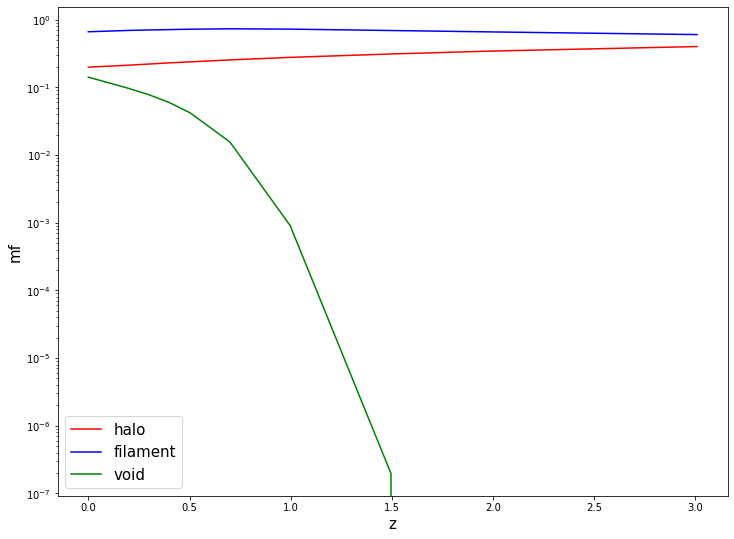

In [10]:
#####################
#plot mass fractions#
#####################

fig=plt.figure(figsize=(12,9))

ax1=fig.add_subplot(111)
ax1.set_xlabel('z',fontsize=15)
ax1.set_ylabel('mf',fontsize=15)
ax1.set_yscale('log')
#ax1.set_ylim([1e-2,1e0])
ax1.plot((allsnaps_redshifts.mean(axis=1))[0:10],hal_frac[0:10],label='halo',color='red')
ax1.plot((allsnaps_redshifts.mean(axis=1))[0:10],fil_frac[0:10],label='filament',color='blue')
ax1.plot((allsnaps_redshifts.mean(axis=1))[0:10],voi_frac[0:10],label='void',color='green')


plt.legend(fontsize=15)
plt.savefig('evolving_mass_fraction_TNG100-{0}.png'.format(TNGversion))
plt.show()

In [11]:
print(allsnaps_dens_crit_array)

[[9.46872009e-27]
 [9.46872009e-27]
 [9.46872009e-27]
 [9.46872009e-27]
 [9.46872009e-27]
 [9.46872009e-27]
 [9.46872009e-27]
 [9.46872009e-27]
 [9.46872009e-27]
 [9.46872009e-27]
 [9.46872009e-27]
 [9.46872009e-27]]


In [12]:
print((allsnaps_redshifts.mean(axis=1))[0:10],fil_frac[0:10],hal_frac[0:10],voi_frac[0:10])

print(fil_frac+hal_frac+voi_frac)


[2.22044605e-16 1.97284182e-01 2.97717685e-01 3.99926965e-01
 5.03047523e-01 7.00106354e-01 9.97294226e-01 1.49551217e+00
 2.00202814e+00 3.00813107e+00] [0.66081941 0.69148391 0.70181405 0.71126391 0.72077177 0.73093712
 0.72266019 0.68967895 0.65678664 0.60047699] [0.19820826 0.21189377 0.22028742 0.22929258 0.23734959 0.25359276
 0.27643662 0.31032085 0.34321336 0.39952301] [1.40972335e-01 9.66223221e-02 7.78985321e-02 5.94435060e-02
 4.18786442e-02 1.54701197e-02 9.03189739e-04 1.95668166e-07
 0.00000000e+00 0.00000000e+00]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
